In [50]:
%matplotlib inline

import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import json

In [51]:
img = cv2.cvtColor(cv2.imread('Example Photos/1f45fbbef74b9409ff59f8b6a973b490.jpg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
#img = cv2.imread('Example Photos/099b331721c6a2a6ed8859d51a5ff091.jpg', cv2.IMREAD_GRAYSCALE)

In [52]:
#imgS = np.copy(img)
imgS = np.zeros(img.shape, dtype = img.dtype)
imgMask = np.ones((img.shape[0], img.shape[1]), dtype = np.float16) * 1e5
imgIDs = np.ones((img.shape[0], img.shape[1]), dtype = np.int16) * -1

In [53]:
def randomPoint(dims):
    return (random.randint(0, dims[0]-1), random.randint(0, dims[1]-1))

In [54]:
def ColourDistance(c1, c2):
    c1 = c1.astype(np.float16)
    c2 = c2.astype(np.float16)
    dR = (c1[0] - c2[0]) * (c1[0] - c2[0])
    dG = (c1[1] - c2[1]) * (c1[1] - c2[1])
    dB = (c1[2] - c2[2]) * (c1[2] - c2[2])
    hr = (c1[0] + c2[0]) / (2 * 256)
    return np.sqrt(((2 + hr) * dR) + (4 * dG) + ((2 + (255/256) - hr) * dB))

def ColourDistanceY(c1, c2):
    c1 = c1.astype(np.float16)
    c2 = c2.astype(np.float16)
    Y1 = 0.299 * c1[0] + 0.587 * c1[1] + 0.114 * c1[2]
    Y2 = 0.299 * c2[0] + 0.587 * c2[1] + 0.114 * c2[2]
    return abs(Y1 - Y2)

def ColourDistanceGray(c1, c2):
    c1 = c1.astype(np.int16)
    c2 = c2.astype(np.int16)
    return abs(c1 - c2)

def PositionDistance(P1, P2):
    return (P1[0] - P2[0]) * (P1[0] - P2[0]) + (P1[1] - P2[1]) * (P1[1] - P2[1])

In [55]:
def AddBoundaryPoints(IMask, pointAdded, imgCols, avgCol):
    lis = []
    temp0 = (pointAdded[0]-1, pointAdded[1])
    if(temp0[0] >= 0):
        dis = ColourDistance(avgCol, imgCols[temp0])
        if(dis < IMask[temp0]):
            lis.append(temp0)
            IMask[temp0] = -IMask[temp0]
    temp0 = (pointAdded[0]+1, pointAdded[1])
    if(temp0[0] < IMask.shape[0]):
        dis = ColourDistance(avgCol, imgCols[temp0])
        if(dis < IMask[temp0]):
            lis.append(temp0)
            IMask[temp0] = -IMask[temp0]
    temp0 = (pointAdded[0], pointAdded[1]-1)
    if(temp0[1] >= 0):
        dis = ColourDistance(avgCol, imgCols[temp0])
        if(dis < IMask[temp0]):
            lis.append(temp0)
            IMask[temp0] = -IMask[temp0]
    temp0 = (pointAdded[0], pointAdded[1]+1)
    if(temp0[1] < IMask.shape[1]):
        dis = ColourDistance(avgCol, imgCols[temp0])
        if(dis < IMask[temp0]):
            lis.append(temp0)
            IMask[temp0] = -IMask[temp0]
    return lis

In [56]:
def fast_exponentiation(base, exponent):
    result = 1
    while exponent > 0:
        if exponent % 2 == 1:
            result *= base
        base *= base
        exponent //= 2
    return result

In [57]:
def Kernel(p1, p2, A, B):
    #fine tune A and B
    dis = np.sqrt((p1[0] - p2[0])*(p1[0] - p2[0]) + (p1[1] - p2[1])*(p1[1] - p2[1]))
    if(dis <= B):
        return -(A/B) * dis + A
    return 0

def KernelAsymp(p1, p2):
    C = 164
    D = 3
    dis = np.sqrt((p1[0] - p2[0])*(p1[0] - p2[0]) + (p1[1] - p2[1])*(p1[1] - p2[1]))
    return C / (dis + D)

def KernelPolyRoot(p1, p2, A, B, a):
    dis = np.sqrt((p1[0] - p2[0])*(p1[0] - p2[0]) + (p1[1] - p2[1])*(p1[1] - p2[1]))
    if(dis <= B):
        return A * (((-dis/B) + 1) ** (a))
    return -1

def KernelPoly(p1, p2, A, B, a):
    dis = np.sqrt((p1[0] - p2[0])*(p1[0] - p2[0]) + (p1[1] - p2[1])*(p1[1] - p2[1]))
    if(dis <= B):
        return A * ( 1 - fast_exponentiation((dis/B), int(a)))
    return -1

In [58]:
def PointCalcDisSort(IMG, lis, avgCol):
    A = []
    for i in range(len(lis)):
        A.append((lis[i], ColourDistance(IMG[lis[i]], avgCol)))
    A.sort(key = lambda a: a[1])
    return A

In [59]:
def AddtoAvgCol(avgC, C1, N):
    C1 = C1.astype(np.float64)
    return ((avgC * N)/(N+1)) + (C1  / (N+1))

In [60]:
def AddtoAvgPos(avgP, P1, N):
    return (((avgP[0] * N) + P1[0] ) / (N+1), ((avgP[1] * N) + P1[1] ) / (N+1))

In [61]:
def RemFromAvgCol(avgC, C1, N):
    if(N == 1):
        return avgC
    return (avgC - (C1 / N)) * (N/(N-1))

In [62]:
def RemFromAvgPos(avgP, P1, N):
    if(N == 1):
        return avgP
    return (((avgP[0] - (P1[0] / N)) * (N/(N-1))), ((avgP[1] - (P1[1] / N)) * (N/(N-1))))

In [63]:
RandPointLen = 10000
RandPoints = [randomPoint(imgMask.shape) for x in range(RandPointLen)]

SizData = []
CenterPoints = []

#RandPointLen = 1
#RandPoints = [(75, 165)]

AVal = 30
BVal = 200
Counter = 0
rat = 768 * 768 / (BVal ** 4)

for k in range(1, RandPointLen+1):
    
    #find point (Remove this part for the time being)
    point = RandPoints[k-1]
#    if(imgMask[point] < 1e4):
#        continue
    
    #Add 3 to the A value every 4000 samples to increase the size of the data acceptable
    Counter += 1
    if((Counter % 400) == 0):
        print(AVal, k, len(CenterPoints))
        AVal *= 1.14
    
    #Array Memory
    toReset = []
    toAvgCol = [point]
    
    #Colour Region From point
    avgPos = point
    avgCol = img[point].astype(np.float64)
    Boundary = AddBoundaryPoints(imgMask, point, img, avgCol)
    imgMask[point] = -imgMask[point]
    siz = 1
    while(len(Boundary) > 0):
        bPoint = Boundary[0]
        ColDis = ColourDistance(avgCol, img[bPoint])
        PosDis = PositionDistance(avgPos, bPoint)
        dis = math.sqrt(ColDis * ColDis + PosDis * PosDis * rat)
        #print(bPoint, avgCol, img[bPoint], dis)
        if(dis < KernelPoly(bPoint, avgPos, AVal, BVal, 2)):
            avgCol = AddtoAvgCol(avgCol, img[bPoint], siz)
            avgPos = AddtoAvgPos(avgPos, bPoint, siz)
            BAdds = AddBoundaryPoints(imgMask, bPoint, img, avgCol)
            Boundary += BAdds
            siz += 1
            toAvgCol.append(bPoint)
        else:
            toReset.append(bPoint)
        Boundary = Boundary[1:]

    if(siz <= 100):
        toReset += toAvgCol
        toAvgCol = []
    else:
        CenterPoints.append((avgPos, avgCol, siz))
        
    for P in toReset:
        imgMask[P] = -imgMask[P]
    for P in toAvgCol:
        prevID = imgIDs[P]
        if(prevID != -1):
            prevAvgPos, prevAvgCol, prevSiz = CenterPoints[prevID]
            CenterPoints[prevID] = (RemFromAvgPos(prevAvgPos, P, prevSiz),
                                    RemFromAvgCol(prevAvgCol, img[P], prevSiz),
                                    prevSiz - 1)
        
        imgIDs[P] = len(CenterPoints)-1
        imgMask[P] = ColourDistanceY(avgCol, img[P])
        imgS[P] = avgCol
        




30 400 189
34.199999999999996 800 352
38.98799999999999 1200 481
44.446319999999986 1600 614
50.66880479999998 2000 741
57.762437471999974 2400 873
65.84917871807997 2800 1000
75.06806373861116 3200 1096
85.57759266201671 3600 1201
97.55845563469904 4000 1280
111.2166394235569 4400 1347
126.78696894285486 4800 1401
144.5371445948545 5200 1455
164.77234483813413 5600 1492
187.8404731154729 6000 1533
214.13813935163907 6400 1573
244.11747886086852 6800 1610
278.2939259013901 7200 1647
317.25507552758467 7600 1674
361.6707861014465 8000 1701
412.30469615564897 8400 1725
470.02735361743976 8800 1750
535.8311831238813 9200 1772
610.8475487612246 9600 1791
696.366205587796 10000 1813


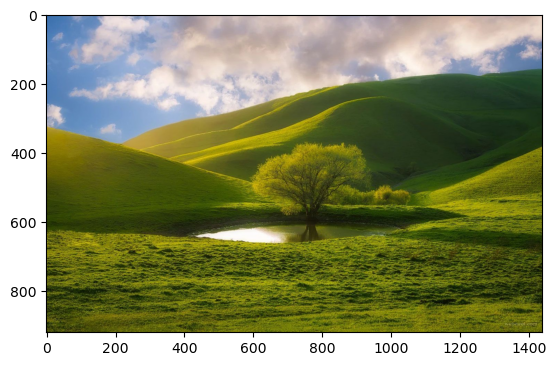

In [64]:
plt.imshow(img)

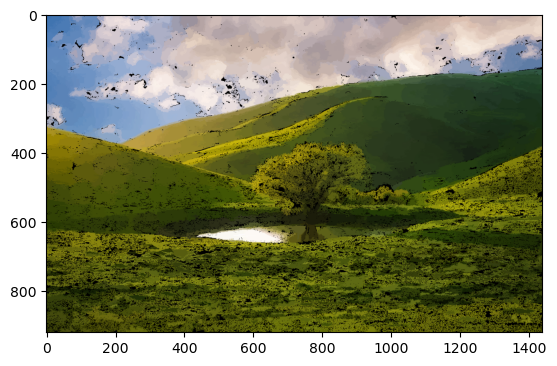

In [65]:
plt.imshow(imgS)

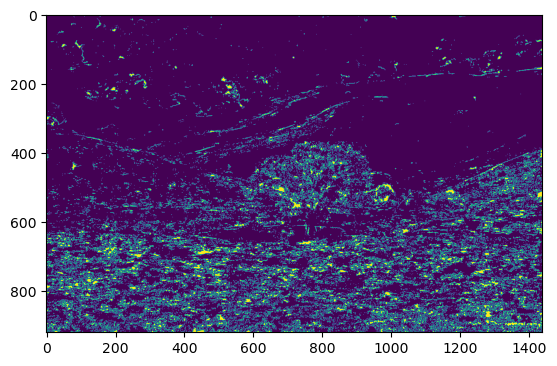

In [66]:
plt.imshow(imgMask)

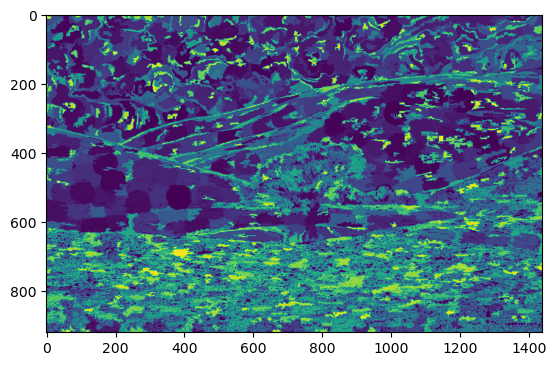

In [67]:
plt.imshow(imgIDs)

In [68]:
cv2.imwrite('Example Photos/Fin1X.jpg', cv2.cvtColor(imgS, cv2.COLOR_RGB2BGR))
cv2.imwrite('Example Photos/Fin1W.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True

In [69]:
for P in CenterPoints:
    InvPoint = (int(P[0][1]), int(P[0][0]))
    Point = (int(P[0][0]), int(P[0][1]))
    R = np.sqrt(P[2]/math.pi)
    cv2.circle(imgS, InvPoint, int(R), (255, 0, 0), 0)
    cv2.circle(imgS, InvPoint, 2, (int(255 - P[1][0]), int(255 - P[1][1]), int(255 - P[1][2])), 0)

In [70]:
cv2.imwrite('Example Photos/Fin1R.jpg', cv2.cvtColor(imgS, cv2.COLOR_RGB2BGR))

True

In [71]:
json_obj = json.dumps([img.shape, [((int(P[0][0]), int(P[0][1])), (int(P[1][0]), int(P[1][1]), int(P[1][2])), P[2]) for P in CenterPoints]])

In [72]:
with open('Example Photos/Fin1.txt', 'w') as f:
    f.write(json_obj)